In [3]:
!pip install gdown
!gdown --id 1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn
!gdown --id 1uiL-O3EtAholf9qrtR8TlppjrGHW10Rh

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn
From (redirected): https://drive.google.com/uc?id=1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn&confirm=t&uuid=38c19f27-1b2c-4e6d-80d1-05f15c5f64cc
To: /kaggle/working/data.pkl
100%|███████████████████████████████████████| 1.24G/1.24G [00:11<00:00, 109MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uiL-O3EtAholf9qrtR8TlppjrGHW10Rh
To: /kaggle/working/3DECGNet.h5
100%|███████████████████████████████████████| 3.57M/3.57M [00:00<00:00, 210MB/s]


In [4]:
import pickle
from tqdm import tqdm
import tensorflow as tf
import numpy as np

from preprocess import data_preparation
from preprocess import signal_cutter
from preprocess import data_filtering
from preprocess import resampling
from preprocess import RP_3D
from preprocess import resize_volume
from preprocess import RP_final_data
from preprocess import label_creator
from preprocess import including_data
from lime_utils import tp_finder
from lime_utils import lead_replacing
from lime_utils import weight_bars

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Read dictionary pkl file
with open('/kaggle/working/data.pkl', 'rb') as fp:
    dataset = pickle.load(fp)

In [6]:
ds = data_preparation(dataset)

# shortening
ds = signal_cutter(ds, d_length=1000)

# denoising
ds = data_filtering(ds)

# resampling
ds = resampling(ds, desired_points = 100)

100%|██████████| 10344/10344 [00:01<00:00, 6100.10it/s]


In [7]:
arr = {'NSR':'426783006', 'AF':'164889003', 'IAVB':'270492004', 'LBBB':'164909002', 'RBBB':'59118001', 'SB':'426177001', 'STach':'427084000'}
labels = label_creator(data_preparation(dataset), arr)
x_train, y_train, x_test, y_test = including_data(labels, ds)
# transformation and resizing
tmp_x_test = RP_final_data(x_test)

100%|██████████| 10344/10344 [00:00<00:00, 791222.24it/s]
10344it [00:09, 1108.35it/s]
10344it [00:05, 1789.68it/s]
100%|██████████| 1126/1126 [06:30<00:00,  2.88it/s]


In [8]:
model = tf.keras.models.load_model('/kaggle/working/3DECGNet.h5')
pred_proba = model.predict(tmp_x_test)
prediction = np.zeros(np.shape(pred_proba))
prediction[pred_proba > 0.5] = 1

36/36 [==============================] - 15s 344ms/step


In [9]:
neigh_mx = lead_replacing()

# !!!!!!Change arrhythmia
tp_samples = tp_finder(prediction, y_test, 'STach', arr)

In [10]:
len(tp_samples)

210

In [16]:
from sklearn.linear_model import LogisticRegression
cof = []
counter = 1

for i in tp_samples[:100]:
    print('sample numbet', counter)
    counter = counter + 1
    neighbors = []
    for j in neigh_mx:
        neighbors.append(j * x_test[i])
    neighbor_tr = RP_final_data(neighbors)
    p = model.predict(neighbor_tr)
    pp = np.zeros(np.shape(p))
    pp[p > 0.5] = 1
    wei = []
    for k in np.squeeze(neigh_mx):
        wei.append(sum(k)/12)
    lr = LogisticRegression()
    
    # !!!!!!Change arrhythmia
    lr.fit(np.squeeze(neigh_mx), pp[:,6], sample_weight = wei)
    
    cof.append(lr.coef_)

sample numbet 1


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 2


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 3


100%|██████████| 793/793 [04:35<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 4


100%|██████████| 793/793 [04:35<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 5


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 6


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 7


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 8


100%|██████████| 793/793 [04:35<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 9


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 10


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 11


100%|██████████| 793/793 [04:35<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 12


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 13


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 14


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 15


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 16


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 17


100%|██████████| 793/793 [04:35<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 18


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 19


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 20


100%|██████████| 793/793 [04:32<00:00,  2.91it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 21


100%|██████████| 793/793 [04:33<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 22


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 23


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 24


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 25


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 26


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 27


100%|██████████| 793/793 [04:33<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 28


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 29


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 30


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 31


100%|██████████| 793/793 [04:32<00:00,  2.91it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 32


100%|██████████| 793/793 [04:32<00:00,  2.91it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 33


100%|██████████| 793/793 [04:32<00:00,  2.91it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 34


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 35


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 36


100%|██████████| 793/793 [04:32<00:00,  2.91it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 37


100%|██████████| 793/793 [04:32<00:00,  2.91it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 38


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 39


100%|██████████| 793/793 [04:32<00:00,  2.91it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 40


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 41


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 342ms/step
sample numbet 42


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 43


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 44


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 45


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 46


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 47


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 48


100%|██████████| 793/793 [04:33<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 49


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 50


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 51


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 52


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 53


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 54


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 55


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 56


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 57


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 58


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 59


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 60


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 61


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 62


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 63


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 64


100%|██████████| 793/793 [04:35<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 65


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 66


100%|██████████| 793/793 [04:34<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 67


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 68


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 69


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 70


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 71


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 72


100%|██████████| 793/793 [04:34<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 73


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 74


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 75


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 76


100%|██████████| 793/793 [04:34<00:00,  2.88it/s]


25/25 [==============================] - 9s 342ms/step
sample numbet 77


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 78


100%|██████████| 793/793 [04:35<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 79


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 80


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 81


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 82


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 83


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 84


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 85


100%|██████████| 793/793 [04:35<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 86


100%|██████████| 793/793 [04:36<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 87


100%|██████████| 793/793 [04:34<00:00,  2.88it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 88


100%|██████████| 793/793 [04:35<00:00,  2.87it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 89


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 90


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 91


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 92


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 93


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 94


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 95


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 96


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 97


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 98


100%|██████████| 793/793 [04:33<00:00,  2.90it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 99


100%|██████████| 793/793 [04:30<00:00,  2.93it/s]


25/25 [==============================] - 9s 343ms/step
sample numbet 100


100%|██████████| 793/793 [04:34<00:00,  2.89it/s]


25/25 [==============================] - 9s 343ms/step


In [17]:
cf2 = np.squeeze(cof)

In [18]:
my_dict = {
    'Lead I':cf2[:,0],
    'Lead II':cf2[:,1],
    'Lead III':cf2[:,2],
    'Lead avF':cf2[:,3],
    'Lead avR':cf2[:,4],
    'Lead avL':cf2[:,5],
    'Lead V1':cf2[:,6],
    'Lead V2':cf2[:,7],
    'Lead V3':cf2[:,8],
    'Lead V4':cf2[:,9],
    'Lead V5':cf2[:,10],
    'Lead V6':cf2[:,11]
}

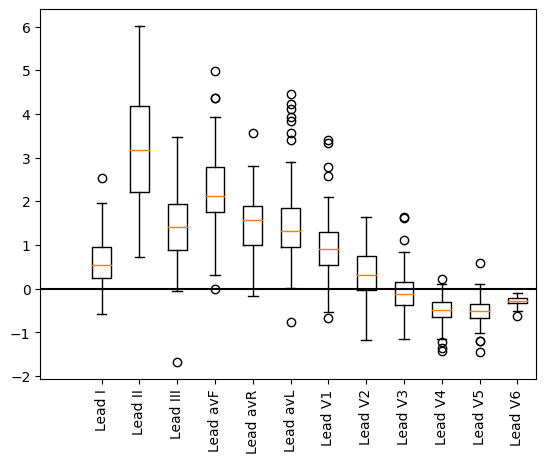

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
plt.axline((0,0),(11,0),color='black')
ax.set_xticklabels(my_dict.keys())
plt.xticks(rotation=90)
plt.show()

In [20]:
np.savez('/kaggle/working/Stachweights_1' , cf2)